In [0]:
%pip install "boto3==1.21.32" "fsspec==2023.10.0" "s3fs==0.4.2"
%pip install "spark-nlp==5.1.4"
%pip install "textblob==0.17.1"

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import os
# To work with Amazon S3 storage, set the following variables using your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = 'abc'
secret_key = 'abc'
# Set the environment variables so boto3 can pick them up later
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"
# Set this to the name of your bucket where the files are stored
aws_bucket_name = "genius-lyrics-ss"
mount_name = "s3dataread"

In [0]:
# Update the Spark options to work with our AWS Credentials
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region +
".amazonaws.com")

In [0]:
# importing neccessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, CountVectorizer, StopWordsRemover, OneHotEncoder, StringIndexer, VectorAssembler, RegexTokenizer
from pyspark.ml.feature import HashingTF, IDF
from textblob import TextBlob
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when
from pyspark.sql.types import StringType
import string
from pyspark.sql.functions import udf, col, lower
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [0]:
# Reading folder with all my parquet files:
lyrics_million = "s3://genius-lyrics-ss/raw/song_lyrics_100000.parquet"
lm_sdf = spark.read.parquet(lyrics_million)
lm_sdf.show()

+--------------------+-------+--------------------+----+--------------------+------+--------+--------------------+
|               title|  genre|              artist|year|            features|    id|language|      lyrics_cleaned|
+--------------------+-------+--------------------+----+--------------------+------+--------+--------------------+
|I Do It For The R...|    rap|          Lil Debbie|2012|                    | 95249|      en|i got bitches you...|
|                 4Gs|    rap|     Statik Selektah|2011|TermanologyScram ...| 95250|      en|verse 1 eay money...|
|  The Vanishing Mind|   rock|            Calexico|2012|                    | 95251|      en|on the longest da...|
|          Crazy Town|country|        Jason Aldean|2009|                    | 95252|      en|verse 1 roll into...|
|             Chillin|    rap|        Backdoe boyz|2012|                    | 95255|      en|1yall aint loud i...|
|New York Citys Ki...|   rock|      Ray LaMontagne|2012|                    | 95

In [0]:
# Function that removes unnecessary words & numbers
def drop_words_int(text, remove_words=['chorus','intro', 'verse']):

    # removing numbers in lyrics as i wont need them
    text = ''.join([char for char in text if not char.isdigit()])

        # removing specific words in my list
    if remove_words:
        for word in remove_words:
            text = text.replace(word, '')

    return text
remove_specific_udf = spark.udf.register("remove_specific_udf", drop_words_int, StringType())

lm_sdf = lm_sdf.withColumn("lyrics_cleaned", remove_specific_udf(col("lyrics_cleaned")))

lm_sdf.show()

+--------------------+-------+--------------------+----+--------------------+------+--------+--------------------+
|               title|  genre|              artist|year|            features|    id|language|      lyrics_cleaned|
+--------------------+-------+--------------------+----+--------------------+------+--------+--------------------+
|I Do It For The R...|    rap|          Lil Debbie|2012|                    | 95249|      en|i got bitches you...|
|                 4Gs|    rap|     Statik Selektah|2011|TermanologyScram ...| 95250|      en|  eay money we go...|
|  The Vanishing Mind|   rock|            Calexico|2012|                    | 95251|      en|on the longest da...|
|          Crazy Town|country|        Jason Aldean|2009|                    | 95252|      en|  roll into town ...|
|             Chillin|    rap|        Backdoe boyz|2012|                    | 95255|      en|yall aint loud in...|
|New York Citys Ki...|   rock|      Ray LaMontagne|2012|                    | 95

In [0]:
# Defining my sentiment analysis 

def sentiment_analysis(tokens):
    if tokens is None:
        return 0.0
    # Check if tokens is a list - was getting a type error
    if isinstance(tokens, list):
        # Convert the list of tokens to a string
        text = ' '.join(tokens)
    else:
        # If not a list, assume it's already a string
        text = str(tokens)
    
    # Perform sentiment analysis on the string
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment


sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

sentiment_lyrics = lm_sdf.withColumn("sentiment_lyrics", sentiment_analysis_udf(lm_sdf['lyrics_cleaned']))
sentiment_title = sentiment_lyrics.withColumn("sentiment_title",sentiment_analysis_udf('title'))

finalSdf = sentiment_title

In [0]:
# Building my features/vectors 

# Defining the columns to index
index_cols = ["genre", "language", "artist"]

# 1 - Indexer 
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}Index", handleInvalid="keep")
    for col in index_cols
]


# 2 - Encoder 
encoders = [
    OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}Encoded")
    for col in index_cols
]
# 3 - Tokenizer 
regexTokenizer = RegexTokenizer(inputCol="lyrics_cleaned", outputCol="tokens", pattern="\\w+", gaps=False)
finalSdf = regexTokenizer.transform(finalSdf)
# 4 - Stop Words Remover 
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="cleanLyrics")
finalSdf = stopwords_remover.transform(finalSdf)

# 5 - HashingTF & idf
hashing_tf = HashingTF(inputCol="cleanLyrics", outputCol="hashedFeatures_tf", numFeatures=4096)
finalSdf = hashing_tf.transform(finalSdf)

idf = IDF(inputCol='hashedFeatures_tf', outputCol="wordFeatures", minDocFreq=1)

finalSdf = idf.fit(finalSdf).transform(finalSdf)

In [0]:
#Sample my data 
finalSdf = finalSdf.sample(False, 0.3)
finalSdf.show()

+--------------------+-------+--------------+----+--------------------+-----+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|  genre|        artist|year|            features|   id|language|      lyrics_cleaned|    sentiment_lyrics|     sentiment_title|              tokens|         cleanLyrics|   hashedFeatures_tf|        wordFeatures|
+--------------------+-------+--------------+----+--------------------+-----+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          Crazy Town|country|  Jason Aldean|2009|                    |95252|      en|  roll into town ...|-0.14794612794612796|                -0.6|[roll, into, town...|[roll, town, step...|(4096,[4,19,78,79...|(4096,[4,19,78,79...|
|             Chillin|    rap|  Backdoe boyz|2012|              

In [0]:
# Assemble the categorical features
assembler_c = VectorAssembler(inputCols=[f"{col}Encoded" for col in index_cols], outputCol="catFeatures")

# Assemble non cat all features
vectorCols = ['sentiment_lyrics', 'sentiment_title', 'wordFeatures']
assembler = VectorAssembler(inputCols=vectorCols, outputCol="featuresAssembled")

In [0]:
lr = LogisticRegression(featuresCol="featuresAssembled", labelCol="genreIndex", maxIter=10, regParam=0.1, elasticNetParam=0.5, family="multinomial")

lyricsPipeline = Pipeline(stages=indexers + encoders + [assembler_c, assembler, lr])

#For testing, see what the assembled feature vector looks like 
test_sdf = lyricsPipeline.fit(finalSdf).transform(finalSdf)

test_sdf.select('catFeatures', 'wordFeatures', 'featuresAssembled').show(10)


+--------------------+--------------------+--------------------+
|         catFeatures|        wordFeatures|   featuresAssembled|
+--------------------+--------------------+--------------------+
|(8009,[5,6,5434],...|(4096,[4,19,78,79...|(4098,[0,1,6,21,8...|
|(8009,[0,6,3940],...|(4096,[48,814,837...|(4098,[0,50,816,8...|
|(8009,[1,6,6807],...|(4096,[46,159,167...|(4098,[0,1,48,161...|
|(8009,[0,6,946],[...|(4096,[10,18,30,3...|(4098,[0,12,20,32...|
|(8009,[0,6,4304],...|(4096,[11,48,55,8...|(4098,[0,13,50,57...|
|(8009,[0,6,208],[...|(4096,[32,81,87,1...|(4098,[0,34,83,89...|
|(8009,[2,6,4235],...|(4096,[10,31,38,4...|(4098,[0,12,33,40...|
|(8009,[0,6,6592],...|(4096,[40,49,121,...|(4098,[0,42,51,12...|
|(8009,[0,6,4117],...|(4096,[26,31,109,...|(4098,[0,28,33,11...|
|(8009,[0,6,1976],...|(4096,[37,53,71,1...|(4098,[0,39,55,73...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [0]:
# Splitting my data
trainingData, testData = finalSdf.randomSplit([0.7, 0.3], seed=789789)


# Training my model 
model = lyricsPipeline.fit(trainingData)


In [0]:
transformedTrainingData = model.transform(trainingData)

predictions = model.transform(testData)

In [0]:
# Access the logistic regression model from the pipeline stages
lr_model = model.stages[8]
# Print the coefficient matrix
print(lr_model.coefficientMatrix.toArray())


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# Assuming 'model' is your trained model after fitting the pipeline
lr_model = model.stages[-1]  # Replace with the correct stage index if needed

# Coefficients
coefficients = lr_model.coefficientMatrix.toArray()


In [0]:
# Assuming 'model' is your trained model after fitting the pipeline
lr_model = model.stages[-1]  # Replace with the correct stage index if needed

# Coefficients
coefficients = lr_model.coefficientMatrix.toArray()


In [0]:
print(coefficients)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
print(model.stages[8].coefficientMatrix.toArray())


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="genreIndex", predictionCol="prediction", metricName="accuracy")
test_accuracy = evaluator.evaluate(predictions)
print("Test Data Accuracy: ", test_accuracy)

# Evaluate precision, recall, and F1-score similarly by changing metricName to "weightedPrecision", "weightedRecall", "f1"



Test Data Accuracy:  0.8797034085878708


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the necessary data in Pandas DataFrames

# Visualization 1: Genre Distribution Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(y='genre', data=your_dataset)
plt.title('Genre Distribution in the Dataset')
plt.xlabel('Number of Songs')
plt.ylabel('Genre')
plt.show()

# Visualization 2: Genre Prediction Accuracy Bar Chart
# You'll need to calculate accuracy per genre from the confusion matrix first
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Genre', data=accuracy_per_genre_df)
plt.title('Model Accuracy by Genre')
plt.xlabel('Accuracy')
plt.ylabel('Genre')
plt.show()

# Visualization 3: Precision and Recall by Genre
plt.figure(figsize=(10, 6))
precision_recall_df.plot(kind='bar', x='Genre')
plt.title('Precision and Recall by Genre')
plt.xlabel('Genre')
plt.ylabel('Score')
plt.show()

# Visualization 4: Feature Importance Heatmap
# This assumes you've transformed the feature importances into a DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance_df, annot=True, cmap='viridis')
plt.title('Feature Importance Heatmap by Genre')
plt.xlabel('Features')
plt.ylabel('Genres')
plt.show()


In [0]:
#saves my model
model.save("s3://genius-lyrics-ss/models/lr_model")



In [0]:
#writes my processed data
predictions.write.parquet("s3://genius-lyrics-ss/trusted/predictions.parquet")


In [0]:
testData.printSchema()


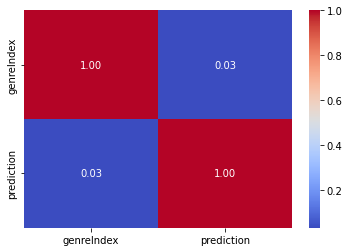

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Making a HeatMap

import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
predictions_heatmap = predictions.select("genreIndex", "prediction").toPandas()

# Create a heatmap
sns.heatmap(predictions_heatmap.corr(), annot=True, cmap="coolwarm", fmt=".2f")

# Show the plot
plt.show()



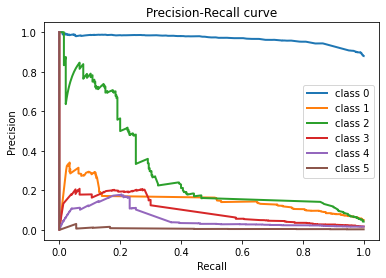

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

predictions_pd = predictions.select(['prediction', 'genreIndex']).toPandas()

# Binarize the labels for multiclass
y_true = label_binarize(predictions_pd['genreIndex'], classes=np.unique(predictions_pd['genreIndex']))
y_scores = np.vstack(predictions.select('probability').rdd.map(lambda row: row['probability'].toArray()).collect())

# Plot Precision-Recall curve for each class
for i in range(y_true.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
plt.title('Precision-Recall curve')
plt.show()


In [0]:
# Save the plot to a buffer
img_data_pr_curve = BytesIO()
plt.savefig(img_data_pr_curve, format='png', bbox_inches='tight')
img_data_pr_curve.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)

# Replace 'your_s3_bucket_path' with your actual bucket path and file name
s3_pr_curve_path = 's3://genius-lyrics-ss/plots/pr_curve.png'

with s3.open(s3_pr_curve_path, 'wb') as f:
    f.write(img_data_pr_curve.read())


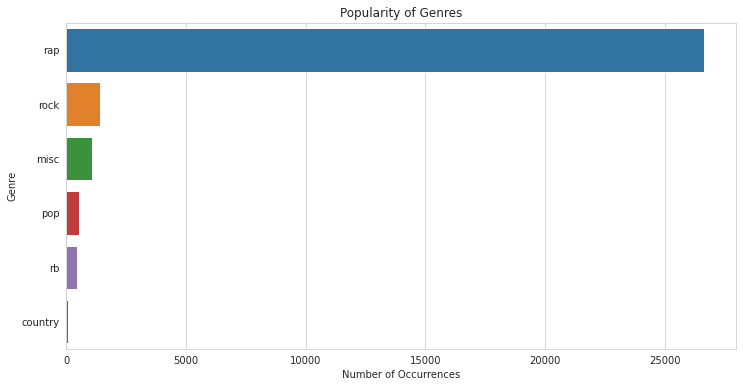

In [0]:
g_sdf = finalSdf.groupBy("genre").count().orderBy(col("count").desc())
genres_pd = g_sdf.toPandas()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot for the genre counts
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genres_pd)
plt.title('Popularity of Genres')
plt.xlabel('Number of Occurrences')
plt.ylabel('Genre')
plt.show()

In [0]:
from io import BytesIO
import matplotlib.pyplot as plt
import s3fs 

# Create a memory buffer to hold the figure
img_data = BytesIO()

# Creating the plot
g_sdf = finalSdf.groupBy("genre").count().orderBy(col("count").desc())
genres_pd = g_sdf.toPandas()

sns.set_style("whitegrid")

# Create a bar plot for the genre counts
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genres_pd)
plt.title('Popularity of Genres')
plt.xlabel('Number of Occurrences')
plt.ylabel('Genre')

# Save the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://genius-lyrics-ss/plots/genre_popularity.png', 'wb') as f:
    f.write(img_data.read())


In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.select(['prediction', 'genreIndex']).rdd.map(lambda row: (float(row['prediction']), float(row['genreIndex'])))

metrics = MulticlassMetrics(predictionAndLabels)

# Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


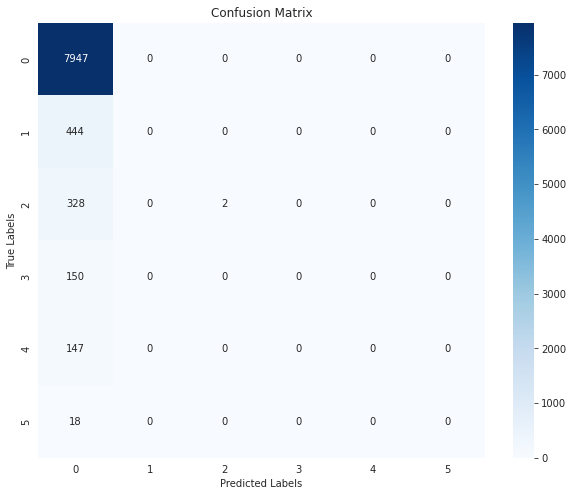

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Adjust the x and y-axis labels if you have specific class names
plt.xticks(ticks=np.arange(0.5, len(metrics.labels)), labels=metrics.labels)
plt.yticks(ticks=np.arange(0.5, len(metrics.labels)), labels=metrics.labels, rotation=0)
plt.show()


In [0]:
# Save the figure to a buffer
img_data_conf_matrix = BytesIO()
plt.savefig(img_data_conf_matrix, format='png', bbox_inches='tight')
img_data_conf_matrix.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)

# Replace 'your_s3_bucket_path' with your actual bucket path and file name
s3_conf_matrix_path = 's3://genius-lyrics-ss/plots/confusion_matrix.png'

with s3.open(s3_conf_matrix_path, 'wb') as f:
    f.write(img_data_conf_matrix.read())


Out[10]: <seaborn.axisgrid.FacetGrid at 0x7f45feef8f40>

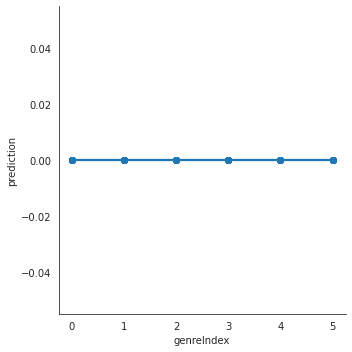

In [0]:
# Plot tip against predicted tip (prediction)
import seaborn as sns

# The Spark dataframe test_results holds the original 'tip' as well as the 'prediction'
# Select and convert to a Pandas dataframe
df = sdf.select('genreIndex','prediction').toPandas()

# Set the style for Seaborn plots
sns.set_style("white")
 
# Create a relationship plot between tip and prediction
sns.lmplot(x='genreIndex', y='prediction', data=df)

In [0]:
# Save the lmplot to a buffer
img_data_lm_plot = BytesIO()
lm_plot.savefig(img_data_lm_plot, format='png', bbox_inches='tight')
img_data_lm_plot.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)

# Replace 'your_s3_bucket_path' with your actual bucket path and file name
s3_lm_plot_path = 's3://genius-lyrics-ss/plots/lm_plot.png'

with s3.open(s3_lm_plot_path, 'wb') as f:
    f.write(img_data_lm_plot.read())

In [0]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up the CrossValidator
crossval = CrossValidator(estimator=lyricsPipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="genreIndex", predictionCol="prediction", metricName="f1"),
                          numFolds=3)

# Fit the model
cvModel = crossval.fit(trainingData)

# Make predictions
cvPredictions = cvModel.transform(testData)

# Evaluate the model
cvAccuracy = evaluator.evaluate(cvPredictions, {evaluator.metricName: "accuracy"})
print("Cross-validated Accuracy:", cvAccuracy)

In [0]:
predictions.select("genreIndex", "prediction").show()


In [0]:
# Check to see where prediction is not 0.0
non_zero_predictions = predictions.filter(col("prediction") != 0.0)

non_zero_predictions.show()